# Build temporal network of PPI with gene expression data from RNA-seq

Here, we build a temporal network of protein-protein interactions (PPI) for the cell cycle of budding yeast, by integrating time series data about gene expression to a static network of PPI.

In [1]:
import string

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sb

import phasik as pk

outdir = "../data/mitocondria"
figdir = "images/mitocondria"

## 1. Load static network

In [2]:
static_net_filepath = "../data_raw/mitochondria/flyInteractome_mitos_FBGN.sif"
static_network = nx.read_adjlist(static_net_filepath, delimiter="\tPPI\t")

pk.graph_size_info(static_network)

'543 nodes and 6154 edges'

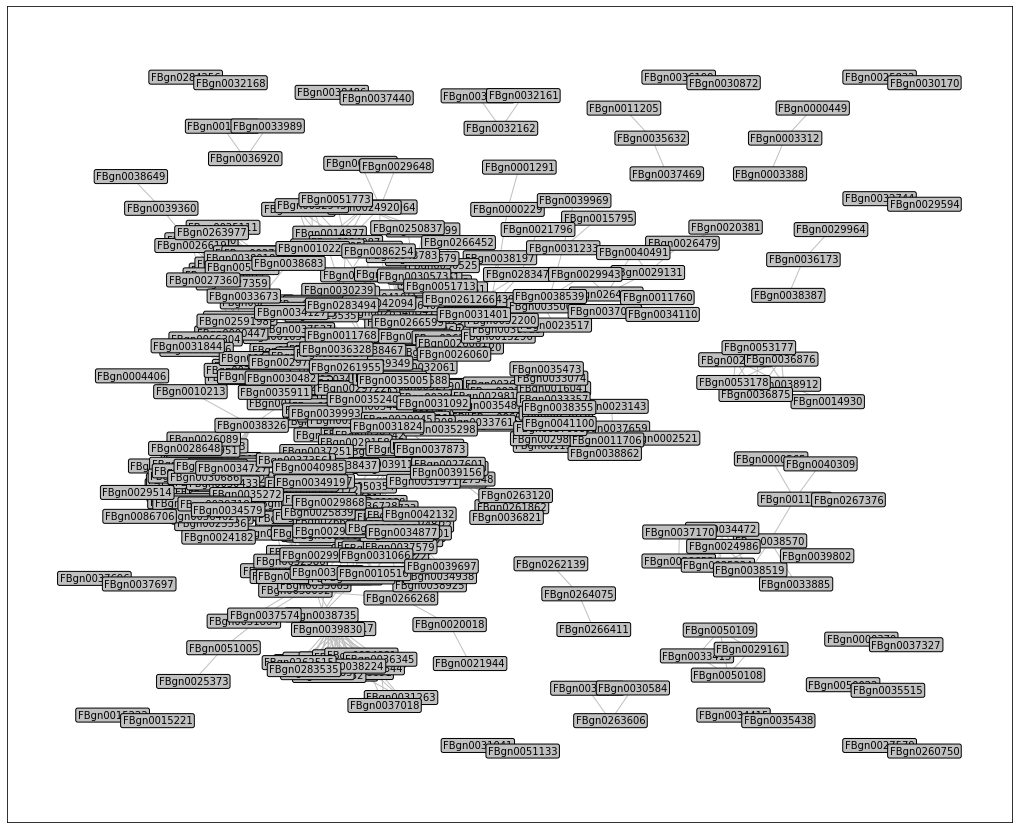

In [3]:
# plot static PPI network
fig, ax = plt.subplots(figsize=(18, 15))

pk.draw_graph(static_network, ax=ax, color="silver")
plt.show()

## 2. Load and format temporal data

### 2.1 Visualise all time points

In [4]:
node_table_filepath = "../data_raw/mitochondria/normalized_ReadCounts_allGenes.txt"

node_series = pd.read_csv(node_table_filepath, sep="\t", index_col="geneID")

# uncomment if we want only the first i_end timepoints
# i_start = 3
# i_end = 23
# node_table = node_table.iloc[:, i_start:i_end]

n_times = node_series.shape[1]
times = list(node_series.columns)
times[0] = "0h"
times[-1] = "100h"
times = [int(t[:-1]) for t in times]
times
node_series.columns = times

node_series

0       16      24       30       48        72        90   \
geneID                                                                       
FBgn0267431        0      74       0        0        0         0         0   
FBgn0267430        0      81      64        0        0         0         0   
FBgn0086917        0      54      40        0        0         0         0   
FBgn0010247      232     535     337      232      232       148         0   
FBgn0086378      417     517     193      188      266        94        62   
...              ...     ...     ...      ...      ...       ...       ...   
FBgn0013685     1965    2379     829     5707    11325     48064     17663   
FBgn0013678    29973   56433   27503    59884   199318    816237    693084   
FBgn0013679    24766   20296   12159    46228   134819    809985    283695   
FBgn0013686  1128691  736996  246656  1314759  3908981  24898229  13099756   
FBgn0013688     5029    1941     388     2184     2672      8824      3634   

                  100  
geneID                 
FBgn0267431         0  
FBgn0267430         0  
FBgn0086917         0  
FBgn0010247        71  
FBgn0086378       125  
...               ...  
FBgn0013685     85648  
FBgn0013678   2017756  
FBgn0013679   1674548  
FBgn0013686  59982898  
FBgn0013688    213743  

[12495 rows x 8 columns]

## 3. Build temporal network

In [5]:
# build temporal network
temporal_network = pk.TemporalNetwork.from_static_network_and_node_timeseries(
    static_network,
    node_series,
    combine_node_weights=lambda x, y: x * y,
    static_edge_default_weight=1,
    normalise="max",
    quiet=True,
)

temporal_network_name = f"mitocondria"

A PartiallyTemporalNetwork is created instead.


In [6]:
print(temporal_network)

<class 'phasik.classes.PartiallyTemporalNetwork.PartiallyTemporalNetwork'> with 543 nodes and 8 times


## Cluster

In [7]:
# clustering parameters
distance_metric = "euclidean"  # used to compute distance between snapshots
clustering_method = "ward"  # used to compute the distance between clusters
n_max_type = "maxclust"  # set number of clusters by maximum number of clusters wanted

n_max = 5  # max number of clusters
n_max_range = range(2, 12)  # range of numbers of clusters to compute

In [8]:
distance_matrix = pk.DistanceMatrix.from_temporal_network(
    temporal_network, distance_metric
)

cluster_set = pk.ClusterSet.from_distance_matrix(
    distance_matrix, n_max_type, n_max, clustering_method
)

/var/folders/w7/qwjxv8yd74s3mjqdnnykkqbc0000gp/T/ipykernel_90255/4184803230.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([""] + tick_labels)
/var/folders/w7/qwjxv8yd74s3mjqdnnykkqbc0000gp/T/ipykernel_90255/4184803230.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([""] + tick_labels)


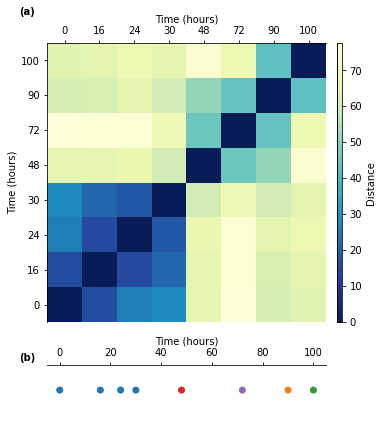

In [9]:
# plot clusters

gs_kw = dict(width_ratios=[1], height_ratios=[6, 1])

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw=gs_kw, sharex=False, figsize=(5, 7))

# distance matrix
im = ax1.imshow(
    distance_matrix.distance_matrix,
    aspect="equal",
    origin="lower",
    cmap="YlGnBu_r",
)
sb.despine(ax=ax1, top=False, bottom=True)

# set time ticks for non-unit time step
def compute_ticklabels(times):

    n_ticks_auto = (
        len(ax1.get_yticks()) - 2
    )  # matplotlib places an extra tick on each side
    n_times = len(times)
    skip = n_times // n_ticks_auto
    return [str(i) for i in times[::skip]]


tick_labels = compute_ticklabels(times)

ax1.set_yticklabels([""] + tick_labels)
ax1.set_xticklabels([""] + tick_labels)

ax1.set_xlabel(f"Time (hours)")
ax1.set_ylabel("Time (hours)")

ax1.xaxis.set_label_position("top")
# ax1.set_title(f"Distance matrix with {distance_metric} distance", weight="bold")

# clusters
cluster_set.plot(ax=ax2)

sb.despine(ax=ax2, left=True, bottom=True, top=False)
# only way to get rid of spine offset in scatter plot apparently
# ax2.set_xlim(0, 101)
ax2.set_yticks([])
# ax2.set_xticks(time_labels)
ax2.set_xlabel(f"Time (hours)")
# ax2.set_title(f"{cluster_set.size} clusters", weight="bold")
ax2.xaxis.set_label_position("top")

# colorbar
cax = fig.add_axes((0, 0, 1, 0.1))
pos1 = ax1.get_position()  # get the original position
pos2 = [
    pos1.x0 + pos1.width + 0.03,
    pos1.y0,
    pos1.width * 0.02,
    pos1.height,
]  # vertical
cax.set_position(pos2)  # set a new position

cb = fig.colorbar(im, cax=cax)
# cb.set_ticks([0, 4, 8])
cb.set_label("Distance")
sb.despine(ax=cax)

# label subplots
for n, ax in enumerate([ax1, ax2]):
    ax.text(
        -0.1,
        1.1,
        f"({string.ascii_lowercase[n]})",
        transform=ax.transAxes,
        size="medium",
        weight="bold",
    )

# Save
if figdir is not None:
    #     pass
    filename = f"{figdir}/distmat_{cluster_set.n_clusters}_clusters_method_{clustering_method}_dist_{distance_metric}_{temporal_network_name}"
#     plt.savefig(f"{filename}.png", dpi=250, bbox_inches="tight")
#     plt.savefig(f"{filename}.svg", dpi=250, bbox_inches="tight")

plt.show()

In [10]:
# range of numbers of clusters
cluster_sets = pk.ClusterSets.from_distance_matrix(
    distance_matrix, n_max_type, n_max_range, clustering_method
)

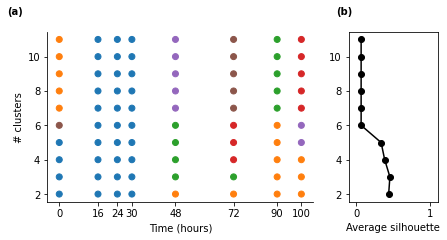

In [11]:
# Plot
gridspec_kw = {"width_ratios": [3, 1]}
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(7, 3.5), gridspec_kw=gridspec_kw, sharey="all"
)

cluster_sets.plot(axs=(ax1, ax2), with_silhouettes=True)
# phases = False
# pk.adjust_margin(ax=ax1, bottom=0.2 if phases else 0.05, top=0.05)
# pk.plot_events(events, ax=ax1)
# plot_phases(phases, ax=ax1, y_pos=0.075, ymax=0.1)

# Format
ax1.set_xlabel(f"Time (hours)")
ax1.set_axisbelow(True)
# ax1.set_ylabel(drawing.display_name(cluster_sets.limit_type))
ax1.set_ylabel("# clusters")
# pk.plot_phases(phases, ax=ax1, y_pos=0.05, ymax=0.1)

time_ticks = times
ax1.set_xticks(time_ticks)
# ax1.set_xticks(time_labels)
sb.despine(ax=ax1)

ax2.set_xlabel("Average silhouette")
ax2.set_xlim((-0.1, 1.1))
ax2.yaxis.set_tick_params(labelleft=True)


# ax3.set_xlabel("Actual # clusters")
# ax3.yaxis.set_tick_params(labelleft=True)

plt.subplots_adjust(wspace=0.2, top=0.8)
# title = f'Clusters and silhouette scores (no thresholding)\n{temporal_network_name}'
# fig.suptitle(title)

# plot_new_events(ax=ax1, ypos=14)

# label subplots
for n, ax in enumerate([ax1, ax2]):
    ax.text(
        -0.15,
        1.1,
        f"({string.ascii_lowercase[n]})",
        transform=ax.transAxes,
        size="medium",
        weight="bold",
    )

# Save
if figdir is not None:
    pass
    filename = f"{figdir}/phase_clusters_all_clusters_method_{clustering_method}_dist_{distance_metric}_{temporal_network_name}"
#     plt.savefig(f"{filename}.png", dpi=250, bbox_inches="tight")
#     plt.savefig(f"{filename}.svg", dpi=250, bbox_inches="tight")

### Aggregate over clusters, and get ranked list of edge activities

In [12]:
# compute list of ranked edges (by weight) for each cluster and save
# do this for several numbers of clusters

n_clusters_id_max = (
    4  # if 0, computes only for 2 clusters, if >0, cluster_sets.n_clusters[j] clusters
)
for j in range(n_clusters_id_max):
    clusters = cluster_sets.clusters[j]
    aggregates = pk.aggregate_network_by_cluster(
        temporal_network, clusters, sort_clusters=False
    )
    n_clusters = len(aggregates)
    print(f"computed for {n_clusters} clusters")

    for i in range(len(aggregates)):

        cluster = list(aggregates.keys())[i]
        network = list(aggregates.values())[i][0]
        time_indices = list(aggregates.values())[i][1]
        edge_weights = pk.weighted_edges_as_df(network)
        edge_weights.to_csv(
            f"{outdir}clusters_{n_clusters}_{i}_timepoints_{time_indices}.csv",
            index=False,
            float_format="%.3f",
        )

computed for 2 clusters
computed for 3 clusters
computed for 4 clusters
computed for 5 clusters


In [13]:
# check the graph of one cluster in particular
n_clusters = 3
clusterset_id = list(cluster_sets.n_clusters).index(n_clusters)
clusters = cluster_sets.clusters[clusterset_id]
# dict with values (aggregated_graph, list of timepoints) for each cluster
aggregates = pk.aggregate_network_by_cluster(
    temporal_network, clusters, sort_clusters=False
)
aggregates

{1: (<networkx.classes.graph.Graph at 0x12e907460>, [0, 1, 2, 3]),
 2: (<networkx.classes.graph.Graph at 0x130516490>, [6, 7]),
 3: (<networkx.classes.graph.Graph at 0x12e85d220>, [4, 5])}

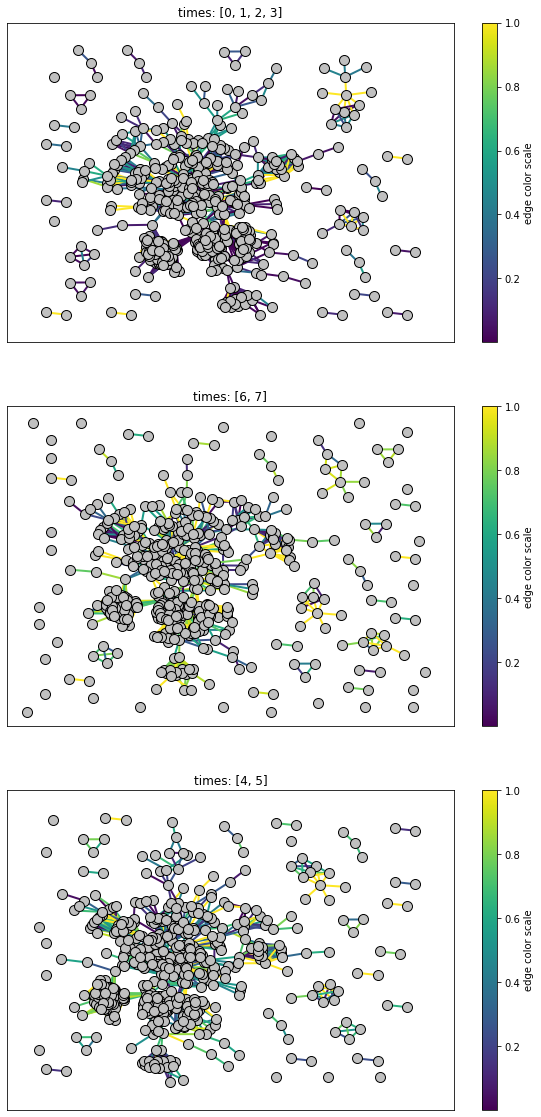

In [14]:
# or color edges by weights

# plot all three clusters

fig, axs = plt.subplots(3, 1, figsize=(10, 20))

for i, j in enumerate(aggregates.keys()):
    G = aggregates[j][0]
    timepoints = aggregates[j][1]

    weights = np.array(list(nx.get_edge_attributes(G, "weight").values()))

    pk.draw_graph(
        G,
        ax=axs[i],
        color="silver",
        label_nodes=False,
        edge_colors=weights,
        edge_widths=2,
    )
    axs[i].set_title(f"times: {timepoints}")

plt.show()